# Import

In [4]:
# Graphics
import matplotlib.pyplot as plt

# Pandas & ML
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

# Third party
import evidently
import shap

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Pandas & ML
from sklearn import metrics, preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)

In [5]:
# load cleaned data
app_train = pd.read_pickle("../data/processed/app_train_cleaned.pkl").set_index(
    "SK_ID_CURR"
)
app_test = pd.read_pickle("../data/processed/app_test_cleaned.pkl").set_index(
    "SK_ID_CURR"
)  # used for datadrift only

In [6]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Columns: 243 entries, NAME_CONTRACT_TYPE to FE_PAYMENT_RATE
dtypes: bool(130), float64(71), int64(42)
memory usage: 305.6 MB


# Split train/test
To keep some test data not seen by gridsearch

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    app_train.drop("TARGET", axis=1), app_train.TARGET, test_size=0.15
)

## Naive undersampler to fix target imbalance

In [8]:
def NaiveUnderSampler(df):
    # find the minority class
    min_class = df.TARGET.value_counts().idxmin()
    # keep same number of majority class than minority
    target_minority_count = df[df.TARGET == min_class].shape[0]
    df_balanced = pd.concat(
        [
            df[df.TARGET == min_class].sample(target_minority_count),
            df[df.TARGET != min_class].sample(target_minority_count),
        ]
    )
    # shuffle rows
    return df_balanced.sample(frac=1)

In [9]:
# create transformer with fit methods from my function
NaiveUnderSamplerTf = FunctionTransformer(NaiveUnderSampler)

In [10]:
# test naive imbalance fixer
app_train.pipe(NaiveUnderSampler).TARGET.value_counts()

TARGET
1    24825
0    24825
Name: count, dtype: int64

# Pipeline

In [11]:
# separate target
# X, y = app_train.drop("TARGET", axis=1), app_train.TARGET
# print(X.shape)
# print(y.shape)

In [12]:
samplerList = [NaiveUnderSamplerTf, RandomUnderSampler()]
pipe = Pipeline(
    [
        ("sampler", RandomUnderSampler()),
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(max_iter=500)),
    ]
)
pipe

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [13]:
grid = GridSearchCV(pipe, param_grid={}, cv=3, n_jobs=-1, verbose=3, scoring="roc_auc")
grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/carl/anaconda3/envs/p7env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('imputer', SimpleImputer()),
                                       ('scaler', MinMaxScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1, param_grid={}, scoring='roc_auc', verbose=3)

In [14]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.268899,0.100141,0.692606,0.084243,{},0.744765,0.741734,0.748485,0.744995,0.002761,1


In [15]:
y_pred = grid.predict(X_test)

In [16]:
y_pred.shape

(46127,)

In [17]:
X_train.shape

(261384, 242)

# Proba predict treshold

In [18]:
# faire varier seuil et afficher graphiquement resultats

In [19]:
# # Make the model with the specified regularization parameter
# log_reg = LogisticRegression(max_iter=500)
# dummy = DummyClassifier()

# # Train on the training data
# log_reg.fit(X_train, y_train)
# # dummy.fit(X_train, y_train)

In [20]:
# y_pred = log_reg.predict(X_test)

In [21]:
# y_pred

# Scoring metric

In [22]:
y_pred.mean()

0.3444837080235003

In [23]:
metrics.accuracy_score(y_test, y_pred)

0.6839378238341969

Sensibilité : 1.00
Spécificité : 0.00
Seuil : 0.00


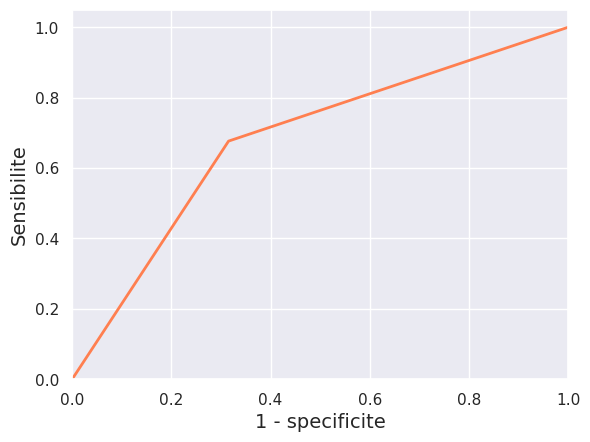

In [24]:
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color="coral", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - specificite", fontsize=14)
plt.ylabel("Sensibilite", fontsize=14)

# indice du premier seuil pour lequel
# la sensibilité est supérieure à 0.95
idx = np.min(np.where(tpr > 0.95))

print("Sensibilité : {:.2f}".format(tpr[idx]))
print("Spécificité : {:.2f}".format(1 - fpr[idx]))
print("Seuil : {:.2f}".format(thr[idx]))

# Profits and Loss function

In [25]:
def human_format(num):
    num = float("{:.3g}".format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return "{}{}".format(
        "{:f}".format(num).rstrip("0").rstrip("."), ["", "K", "M", "B", "T"][magnitude]
    )

In [26]:
# compute mean ratio of value of goods, and amount loaned for buying this goods
GOODS_CREDIT_RATIO = (
    app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_GOODS_PRICE
    / app_train[app_train["AMT_GOODS_PRICE"].notna()].AMT_CREDIT
).mean()


def pnl(y_pred, y_true, interest=0.04, goods_recover_rate=0.60):
    # ajouter type casting
    # todo X en param
    # df.apply(pnl)
    # y_proba
    # interest  et GOODS_P en param
    # interest = 0.04
    # goods_recover_rate = 0.60
    credit = app_train.loc[X_test.index, "AMT_CREDIT"]
    # when goods value is missing, use 90% of credit amount
    seized_goods = (
        np.where(
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"].notna(),
            app_train.loc[X_test.index, "AMT_GOODS_PRICE"],
            app_train.loc[X_test.index, "AMT_CREDIT"] * GOODS_CREDIT_RATIO,
        )
        * goods_recover_rate
    )
    pnl = pd.Series(np.nan)
    # TP : pret refusé correctement = pas de perte
    pnl = np.where((y_pred == 1) & (y_true == 1), 0, pnl)
    # FP : pret refusé par erreur : perte des interets
    pnl = np.where(
        (y_pred == 1) & (y_true == 0),
        -credit * interest,
        pnl,
    )
    # TN : pret accordé correctement : gain des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 0),
        credit * interest,
        pnl,
    )
    # FN : pret accordé par erreur : perte du montant du pret et des interets
    pnl = np.where(
        (y_pred == 0) & (y_true == 1),
        -credit * (1 + interest) + seized_goods,
        pnl,
    )
    return pnl.sum()

In [27]:
print("P&L avec prédictions modèle : $", human_format(pnl(y_pred, y_test)))
print("P&L avec prédictions parfaites : $", human_format(pnl(y_test, y_test)))

P&L avec prédictions modèle : $ 70.3M
P&L avec prédictions parfaites : $ 1.02B


In [28]:
y_pred.mean()

0.3444837080235003

In [29]:
y_test.mean()

0.08049515468163983

## Essai non concluant : calculer intérêts et durée du prêt en fonction du montant total et de l'annuity

In [30]:
app_train[["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]].sample(10)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
SK_ID_CURR,,,
269632,94500.0,10305.0,94500.0
432768,536917.5,17874.0,463500.0
159443,1056447.0,31018.5,922500.0
282310,592560.0,32274.0,450000.0
173162,504000.0,33948.0,504000.0
405305,904500.0,38452.5,904500.0
390138,535500.0,20880.0,535500.0
226489,180000.0,9000.0,180000.0
255802,383760.0,41458.5,360000.0


In [31]:
(app_train.AMT_ANNUITY / app_train.AMT_CREDIT).describe()

# app_train.AMT_CREDIT * 1.0665 / app_train.AMT_ANNUITY

count    307499.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
dtype: float64

# Shap values

In [32]:
explainer = shap.LinearExplainer(grid.best_estimator_["classifier"], X_train)
shap_values = explainer.shap_values(X_test)
shap_values

array([[0.023686028871061835, -0.12611303382649408, 0.015452341051643904,
        ..., -18585.752013454792, 0.13888697393162577,
        0.008233334901953934],
       [0.023686028871061835, -0.12611303382649408, 0.015452341051643904,
        ..., 4457.610449844991, -0.06598969287465027,
        -0.0033580069572643786],
       [0.023686028871061835, -0.12611303382649408, 0.015452341051643904,
        ..., 27500.972913144775, -0.0580601997154653,
        -0.00014473657796513839],
       ...,
       [0.023686028871061835, -0.12611303382649408,
        -0.041778551732222405, ..., -21146.1256204881,
        0.29766209018871465, 0.015099688528579281],
       [0.023686028871061835, -0.12611303382649408, 0.015452341051643904,
        ..., -19609.901456268115, 0.19329088670863118,
        0.010961088269109104],
       [0.023686028871061835, 0.07406638494571874, 0.015452341051643904,
        ..., -21658.20034189476, 0.3814030955419096,
        0.011088290546501962]], dtype=object)

In [33]:
X_train.sample()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,FE_DAYS_EMPLOYED_PERC,FE_INCOME_CREDIT_PERC,FE_INCOME_PER_PERSON,FE_ANNUITY_INCOME_PERC,FE_PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384317,1,1,1,0,135000.0,157500.0,7875.0,157500.0,0.019101,-23315,...,True,False,False,True,False,NaN,0.857143,67500.0,0.058333,0.05


In [34]:
explainer

In [35]:
len(shap_values)

46127

In [36]:
grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler()), ('imputer', SimpleImputer()),
                ('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [37]:
X_test.shape

(46127, 242)

In [38]:
X_test.shape

(46127, 242)

In [39]:
def shap_for_one(df, idx):
    """
    Return 20
    TODO
    """
    shap_for_sample = pd.DataFrame(explainer.shap_values(df.loc[idx, :])).fillna(0)
    shap_OK = StandardScaler().fit_transform(shap_for_sample)
    shap_OK = pd.DataFrame(shap_OK, index=df.columns)
    shap_OK = pd.Series(shap_OK.iloc[:, 0])
    top_shap = shap_OK.sort_values(ascending=False).head(10)
    bottom_shap = shap_OK.sort_values(ascending=True).head(10)
    return {"top": top_shap.to_dict(), "bottom": bottom_shap.to_dict()}


shap_for_one(X_test, X_test.sample().index[0])

{'top': {'AMT_GOODS_PRICE': 13.953881373209821,
  'AMT_CREDIT': 6.670295198363223,
  'AMT_ANNUITY': 0.6703985469159868,
  'DAYS_REGISTRATION': -0.04252722593149066,
  'DAYS_BIRTH': -0.06663027902020652,
  'DAYS_LAST_PHONE_CHANGE': -0.07373314093827939,
  'DAYS_ID_PUBLISH': -0.07948292056632375,
  'OCCUPATION_TYPE_Drivers': -0.08597981360004839,
  'EXT_SOURCE_2': -0.08598207054023795,
  'FLAG_DOCUMENT_3': -0.08598879224264903},
 'bottom': {'FE_INCOME_PER_PERSON': -0.732577993893842,
  'AMT_INCOME_TOTAL': -0.26313929028249866,
  'NAME_TYPE_SUITE_Family': -0.08599519991272139,
  'FLAG_WORK_PHONE': -0.08599506609334583,
  'NAME_EDUCATION_TYPE_Higher education': -0.08599503821677627,
  'FLAG_EMP_PHONE': -0.08599495460441414,
  'OCCUPATION_TYPE_Laborers': -0.0859948515323052,
  'FLAG_DOCUMENT_6': -0.08599484379359817,
  'ORGANIZATION_TYPE_Self-employed': -0.08599465109342819,
  'NAME_FAMILY_STATUS_Married': -0.08599463811304212}}

In [40]:
idx = X_test.sample().index[0]

In [41]:
X_test.loc[X_test.sample().index[0], :]

NAME_CONTRACT_TYPE               0
FLAG_OWN_CAR                     1
FLAG_OWN_REALTY                  1
CNT_CHILDREN                     0
AMT_INCOME_TOTAL          238500.0
                            ...   
FE_DAYS_EMPLOYED_PERC          NaN
FE_INCOME_CREDIT_PERC     0.266332
FE_INCOME_PER_PERSON      119250.0
FE_ANNUITY_INCOME_PERC    0.159623
FE_PAYMENT_RATE           0.042513
Name: 154164, Length: 242, dtype: object

In [42]:
def shap_for_one(df, idx):
    """
    Return 10 top
    """
    shap_for_sample = pd.DataFrame(explainer.shap_values(df.loc[idx, :])).fillna(0)
    shap_OK = StandardScaler().fit_transform(shap_for_sample)
    shap_OK = pd.DataFrame(shap_OK, index=df.columns)
    shap_OK = pd.Series(shap_OK.iloc[:, 0])
    top_shap = shap_OK.sort_values(ascending=False).head(10)
    bottom_shap = shap_OK.sort_values(ascending=True).head(10)
    return {"top": top_shap.to_dict(), "bottom": bottom_shap.to_dict()}


shap_for_one(X_test, X_test.sample().index[0])

{'top': {'AMT_CREDIT': 7.927867313897597,
  'AMT_ANNUITY': 0.19684753577792904,
  'FE_INCOME_PER_PERSON': 0.1093286305541724,
  'FLAG_DOCUMENT_3': 0.021749951803468916,
  'NAME_INCOME_TYPE_Pensioner': 0.021749906930483436,
  'NAME_EDUCATION_TYPE_Secondary / secondary special': 0.021749860054906266,
  'FE_ANNUITY_INCOME_PERC': 0.02174980923235317,
  'FLAG_OWN_CAR': 0.021749743114687848,
  'NAME_FAMILY_STATUS_Married': 0.02174967107781619,
  'NAME_TYPE_SUITE_Unaccompanied': 0.02174964417805795},
 'bottom': {'AMT_GOODS_PRICE': -13.378586832786091,
  'AMT_INCOME_TOTAL': 0.0023488610042824596,
  'DAYS_REGISTRATION': 0.015034863053590792,
  'DAYS_LAST_PHONE_CHANGE': 0.01887941954803854,
  'DAYS_BIRTH': 0.020332085217064113,
  'DAYS_ID_PUBLISH': 0.020335736226425438,
  'EXT_SOURCE_2': 0.02174819929762897,
  'WALLSMATERIAL_MODE_Panel': 0.02174893198473979,
  'CNT_FAM_MEMBERS': 0.02174900922657244,
  'ORGANIZATION_TYPE_Medicine': 0.021749040142446132}}

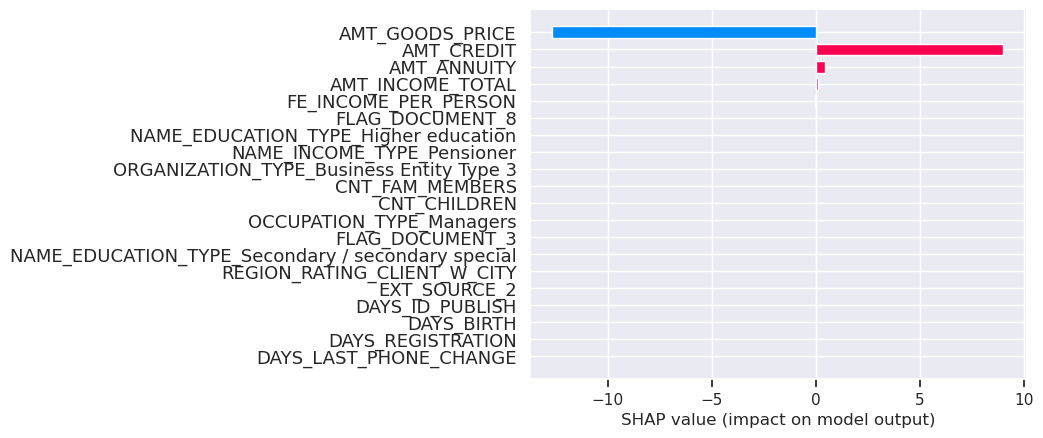

In [44]:
shap_dict = shap_for_one(X_test, X_test.sample().index[0])
# merge top and bottom into one dict
shap_dict["top"].update(shap_dict["bottom"])
keys = np.fromiter(shap_dict["top"].keys(), dtype=object)
values = np.fromiter(shap_dict["top"].values(), dtype=float)
shap.bar_plot(
    values,
    feature_names=keys,
    max_display=20,
)

In [45]:
np.fromiter(shap_dict["top"].keys(), dtype=object)

array(['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'FLAG_DOCUMENT_8',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_INCOME_TYPE_Pensioner',
       'ORGANIZATION_TYPE_Business Entity Type 3', 'CNT_FAM_MEMBERS',
       'CNT_CHILDREN', 'OCCUPATION_TYPE_Managers', 'AMT_GOODS_PRICE',
       'FE_INCOME_PER_PERSON', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'EXT_SOURCE_2', 'REGION_RATING_CLIENT_W_CITY',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'FLAG_DOCUMENT_3'], dtype=object)

In [46]:
explainer.shap_values(X_test.sample(1))[0]

array([0.023686028871061835, -0.12611303382649408, -0.041778551732222405,
       0.26175112030388165, 6131.388806946246, 629619.9725271832,
       -4111.603924260287, -846495.5192703957, -1.5121235385316186e-05,
       34.144483826195696, nan, -539.2325820140611, 722.2058157573086,
       nan, 0.0, -0.03143783358815674, -0.0342010499188731, 0.0,
       0.018504887867588943, 0.000411761904061999, 0.26189783596342675,
       0.0008946439861158157, 0.009701086340589318,
       -0.0026470617829481005, 0.00247924292441512, 0.0010477221341784223,
       0.0019365482029338969, -0.017304598997942212, 0.013226049336756002,
       -0.011805820702591887, nan, -0.08703429672649124, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, 303.87356202525217, 0.0,
       0.12129426643796945, 

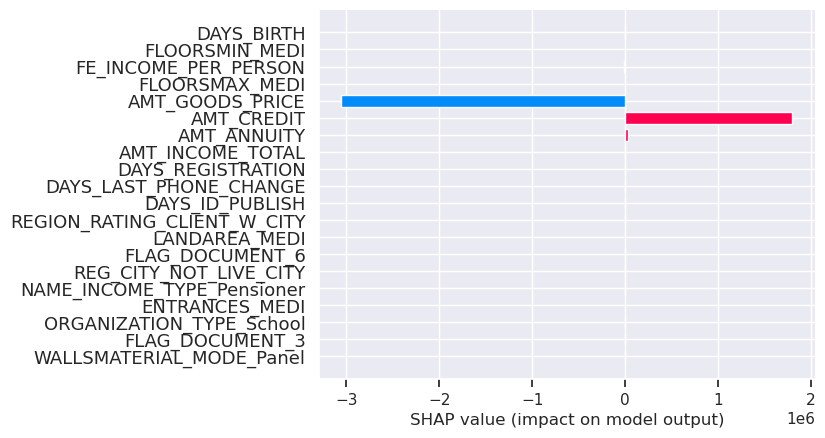

In [47]:
# explainer for only 1 sample row
# TODO prendre que les tops
shap.bar_plot(
    explainer.shap_values(X_test.sample(1))[0],
    feature_names=X_test.columns,
    max_display=20,
)

In [48]:
# shap.plots.beeswarm(explainer.shap_values(X_test))

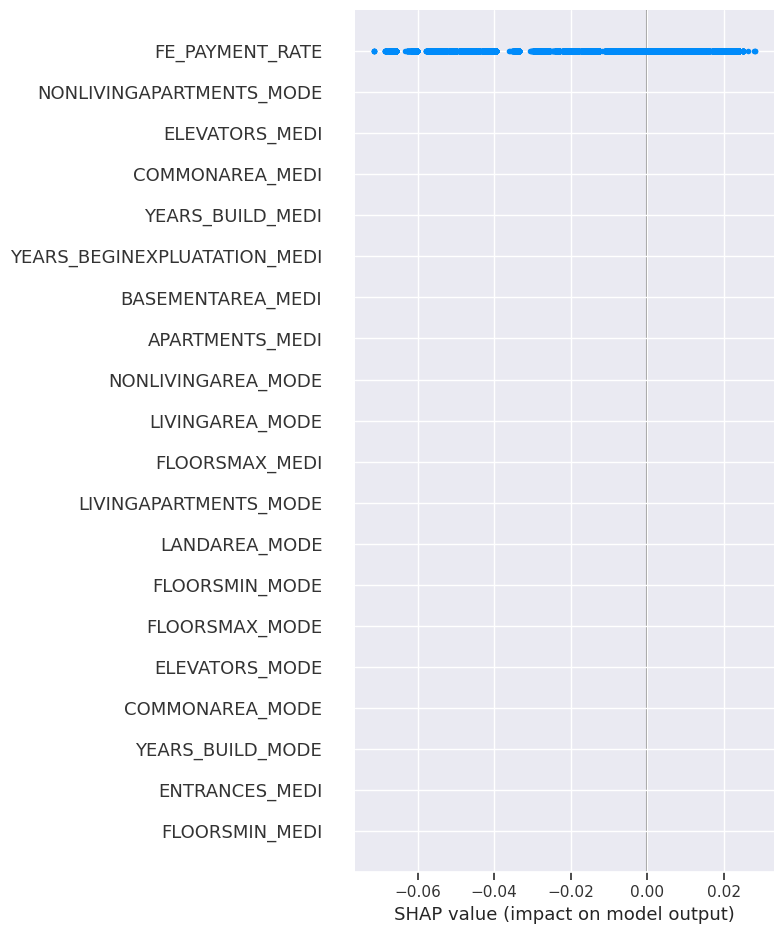

In [49]:
shap.summary_plot(
    explainer.shap_values(X_test).astype(float),
    feature_names=X_test.columns,
    # use_log_scale=True,
)

# Data Drift
Pour simuler évolution des commportements utilisateurs dans le temps, on fait l'hypothèse que `app_train` représente les données d'entrainement et `app_test` les données de test.  
On applique le même nettoyage à train et test

In [50]:
# Third party
from evidently.metric_preset import DataDriftPreset
from evidently.report import Report

# data_drift_report = Report(
#     metrics=[
#         DataDriftPreset(),
#     ]
# )

# data_drift_report.run(
#     reference_data=app_train.sample(frac=0.05).drop("TARGET", axis=1),
#     current_data=app_test.sample(frac=0.05),
#     # column_mapping=None,
# )

# data_drift_report.save_html("../reports/data_drift_report.html")

In [51]:
# ! firefox ../reports/data_drift_report.html

# Save trained model

In [52]:
# Standard
import pickle

with open("../models/model.pkl", "wb") as f:
    pickle.dump(grid.best_estimator_, f)
with open("../models/shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

f.close()

In [53]:
grid.best_estimator_.predict_proba(pd.DataFrame(X_test.iloc[0, :]).T)

array([[0.68895223, 0.31104777]])